In [ ]:
#Importing Packages
import torch
import torch.optim as optim
import torch.nn as nn
from torch.optim.lr_scheduler import ReduceLROnPlateau
from torch.utils.data import TensorDataset, DataLoader
import torch.nn.functional as F
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import matplotlib.colors
from sklearn.preprocessing import StandardScaler
from sklearn.metrics import confusion_matrix, roc_curve, auc
import matplotlib.cm as mpl_cm
import os
from sklearn.model_selection import train_test_split as tts
from sklearn.preprocessing import LabelEncoder

In [3]:
#Move to CUDA if available
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print(f"Using device: {device}")

Using device: cuda


In [4]:
# #Importing data from UNSW_NB15
# train_df = pd.read_csv('data/UNSW_NB15_training-set.csv')
# test_df = pd.read_csv('data/UNSW_NB15_testing-set.csv')
# https://www.kaggle.com/datasets/samayashar/fraud-detection-transactions-dataset
df = pd.read_csv('data/synthetic_fraud_dataset.csv')

df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 50000 entries, 0 to 49999
Data columns (total 21 columns):
 #   Column                        Non-Null Count  Dtype  
---  ------                        --------------  -----  
 0   Transaction_ID                50000 non-null  object 
 1   User_ID                       50000 non-null  object 
 2   Transaction_Amount            50000 non-null  float64
 3   Transaction_Type              50000 non-null  object 
 4   Timestamp                     50000 non-null  object 
 5   Account_Balance               50000 non-null  float64
 6   Device_Type                   50000 non-null  object 
 7   Location                      50000 non-null  object 
 8   Merchant_Category             50000 non-null  object 
 9   IP_Address_Flag               50000 non-null  int64  
 10  Previous_Fraudulent_Activity  50000 non-null  int64  
 11  Daily_Transaction_Count       50000 non-null  int64  
 12  Avg_Transaction_Amount_7d     50000 non-null  float64
 13  F

In [5]:
object_cols = ['Transaction_Type', 'Timestamp', 'Device_Type', 'Location', 'Merchant_Category', 'Card_Type', 'Authentication_Method']


le = LabelEncoder()

for col in object_cols:
    df[col] = le.fit_transform(df[col])

train_df, temp_df = tts(df, test_size=0.4)
test_df, val_df = tts(temp_df, test_size=0.5)


In [6]:
train_df.info()

<class 'pandas.core.frame.DataFrame'>
Index: 30000 entries, 26333 to 41164
Data columns (total 21 columns):
 #   Column                        Non-Null Count  Dtype  
---  ------                        --------------  -----  
 0   Transaction_ID                30000 non-null  object 
 1   User_ID                       30000 non-null  object 
 2   Transaction_Amount            30000 non-null  float64
 3   Transaction_Type              30000 non-null  int64  
 4   Timestamp                     30000 non-null  int64  
 5   Account_Balance               30000 non-null  float64
 6   Device_Type                   30000 non-null  int64  
 7   Location                      30000 non-null  int64  
 8   Merchant_Category             30000 non-null  int64  
 9   IP_Address_Flag               30000 non-null  int64  
 10  Previous_Fraudulent_Activity  30000 non-null  int64  
 11  Daily_Transaction_Count       30000 non-null  int64  
 12  Avg_Transaction_Amount_7d     30000 non-null  float64
 13  Fa

In [7]:
test_df.info()

<class 'pandas.core.frame.DataFrame'>
Index: 10000 entries, 34712 to 36025
Data columns (total 21 columns):
 #   Column                        Non-Null Count  Dtype  
---  ------                        --------------  -----  
 0   Transaction_ID                10000 non-null  object 
 1   User_ID                       10000 non-null  object 
 2   Transaction_Amount            10000 non-null  float64
 3   Transaction_Type              10000 non-null  int64  
 4   Timestamp                     10000 non-null  int64  
 5   Account_Balance               10000 non-null  float64
 6   Device_Type                   10000 non-null  int64  
 7   Location                      10000 non-null  int64  
 8   Merchant_Category             10000 non-null  int64  
 9   IP_Address_Flag               10000 non-null  int64  
 10  Previous_Fraudulent_Activity  10000 non-null  int64  
 11  Daily_Transaction_Count       10000 non-null  int64  
 12  Avg_Transaction_Amount_7d     10000 non-null  float64
 13  Fa

In [8]:
val_df.info()

<class 'pandas.core.frame.DataFrame'>
Index: 10000 entries, 22948 to 30203
Data columns (total 21 columns):
 #   Column                        Non-Null Count  Dtype  
---  ------                        --------------  -----  
 0   Transaction_ID                10000 non-null  object 
 1   User_ID                       10000 non-null  object 
 2   Transaction_Amount            10000 non-null  float64
 3   Transaction_Type              10000 non-null  int64  
 4   Timestamp                     10000 non-null  int64  
 5   Account_Balance               10000 non-null  float64
 6   Device_Type                   10000 non-null  int64  
 7   Location                      10000 non-null  int64  
 8   Merchant_Category             10000 non-null  int64  
 9   IP_Address_Flag               10000 non-null  int64  
 10  Previous_Fraudulent_Activity  10000 non-null  int64  
 11  Daily_Transaction_Count       10000 non-null  int64  
 12  Avg_Transaction_Amount_7d     10000 non-null  float64
 13  Fa

In [9]:
#Collecting required features

feature_columns = ['Transaction_Amount', 'Transaction_Type', 'Account_Balance', 'Location', 'Merchant_Category', 'IP_Address_Flag','Card_Type', 'Authentication_Method', 'Daily_Transaction_Count', 'Card_Age', 'Transaction_Distance', 'Risk_Score', 'Is_Weekend', 'Failed_Transaction_Count_7d', 'Avg_Transaction_Amount_7d', 'Previous_Fraudulent_Activity']

target = 'Fraud_Label'

X_train = train_df[feature_columns].values
y_train = train_df[target].values

#
# le = pre.LabelEncoder()
# train_df['attack_cat_encoded'] = le.fit_transform(train_df['attack_cat'])

X_test = test_df[feature_columns].values
y_test = test_df[target].values

X_val = val_df[feature_columns].values
y_val = val_df[target].values


In [10]:
# original_train_rows = len(train_df)
# train_df = train_df[~((train_df['oldbalanceOrg'] == 0) & (train_df['newbalanceOrig'] == 0))]
# train_df = train_df[~((train_df['oldbalanceDest'] == 0) & (train_df['oldbalanceDest'] == 0))]
# filtered_train_rows = len(train_df)
# print(f"Train_df: Filtered {original_train_rows - filtered_train_rows} rows where oldbalanceOrg and newbalanceOrig were both 0.")
# print(f"Remaining train_df rows: {filtered_train_rows}")
#
# original_test_rows = len(test_df)
# test_df = test_df[~((test_df['oldbalanceOrg'] == 0) & (test_df['newbalanceOrig'] == 0))]
# test_df = test_df[~((test_df['oldbalanceDest'] == 0) & (test_df['newbalanceDest'] == 0))]
# filtered_test_rows = len(test_df)
# print(f"Test_df: Filtered {original_test_rows - filtered_test_rows} rows where oldbalanceOrg and newbalanceOrig were both 0.")
# print(f"Remaining test_df rows: {filtered_test_rows}")


In [11]:
#Converting to tensor
scaler = StandardScaler()

X_train_scaled = scaler.fit_transform(X_train)
X_test_scaled = scaler.transform(X_test)
X_val_scaled = scaler.transform(X_val)

# Converting to tensor and moving to the selected device

X_train_tensor = torch.tensor(X_train_scaled, dtype=torch.float32).unsqueeze(1).to(device)
y_train_tensor = torch.tensor(y_train, dtype=torch.long).to(device)

X_test_tensor = torch.tensor(X_test_scaled, dtype=torch.float32).unsqueeze(1).to(device)
y_test_tensor = torch.tensor(y_test, dtype=torch.long).to(device)

X_val_tensor = torch.tensor(X_val_scaled, dtype=torch.float32).unsqueeze(1).to(device)
y_val_tensor = torch.tensor(y_val, dtype=torch.long).to(device)

In [12]:
BATCH_SIZE = 64
train_dataset = TensorDataset(X_train_tensor, y_train_tensor)
train_loader = DataLoader(train_dataset, batch_size=BATCH_SIZE, shuffle=True)

test_dataset = TensorDataset(X_test_tensor, y_test_tensor)
test_loader = DataLoader(test_dataset, batch_size=BATCH_SIZE, shuffle=False)

val_dataset = TensorDataset(X_val_tensor, y_val_tensor)
val_loader = DataLoader(val_dataset, batch_size=BATCH_SIZE, shuffle=False)
print("Data loaded from CSV and prepared for PyTorch.")
print("Training data shape:", X_train_tensor.shape)
print("Test data shape:", X_test_tensor.shape)
print(f"Number of unique labels (classes): {len(np.unique(y_train))}")


Data loaded from CSV and prepared for PyTorch.
Training data shape: torch.Size([30000, 1, 16])
Test data shape: torch.Size([10000, 1, 16])
Number of unique labels (classes): 2


In [13]:
class Net1DCNN(nn.Module):
    def __init__(self, input_channels, sequence_length, num_classes):
        super(Net1DCNN, self).__init__()

        self.conv1 = nn.Conv1d(in_channels=input_channels, out_channels=16, kernel_size=3, padding=1)
        self.relu1 = nn.ReLU()
        self.pool1 = nn.MaxPool1d(kernel_size=2, stride=2)

        self.conv2 = nn.Conv1d(in_channels=16, out_channels=32, kernel_size=3, padding=1)
        self.relu2 = nn.ReLU()
        self.pool2 = nn.MaxPool1d(kernel_size=2, stride=2)


        # self.fc1 = nn.Linear(160 * 1, 64)
        # self.fc2 = nn.Linear(64, num_classes)

        with torch.no_grad():
            dummy_input = torch.randn(1, input_channels, sequence_length)
            dummy_output = self.pool1(self.relu1(self.conv1(dummy_input)))
            dummy_output = self.pool2(self.relu2(self.conv2(dummy_output)))
            flattened_size = dummy_output.view(dummy_output.size(0), -1).shape[1]

        self.fc1 = nn.Linear(flattened_size, 32)
        self.relu_fc = nn.ReLU()
        self.fc2 = nn.Linear(32, num_classes)

        self.dropout1 = nn.Dropout(p=0.4)
        self.dropout2 = nn.Dropout(p=0.4)

    def forward(self, x):
        x = self.conv1(x)
        x = self.relu1(x)
        x = self.pool1(x)

        # x = self.conv2(x)
        # x = self.relu2(x)
        # x = self.pool2(x)

        x = x.view(x.size(0), -1)
        x = self.dropout1(x)

        x = self.fc1(x)
        x = self.relu_fc(x)
        x = self.dropout2(x)

        x = self.fc2(x)
        return x


In [14]:
input_channels = X_train_tensor.shape[1]
sequence_length = X_train_tensor.shape[2]
num_classes = len(np.unique(y_train))

model = Net1DCNN(input_channels=input_channels, sequence_length=sequence_length, num_classes=num_classes).to(device)
criterion = nn.CrossEntropyLoss()

#Optimizers
optimizer = optim.Adam(model.parameters(), lr=0.0001, weight_decay=1e-2)
# optimizer = optim.SGD(model.parameters(), lr=0.002, momentum=0.001)
# scheduler = ReduceLROnPlateau(optimizer, mode='max', factor=0.05, patience=2)

num_epochs = 20
taccuracy_1dcnn = []
print("\nStarting model training...")
for epoch in range(num_epochs):
    model.train()
    running_loss = 0.0
    for inputs, labels in train_loader:
        inputs, labels = inputs.to(device), labels.to(device)

        optimizer.zero_grad()
        outputs = model(inputs)
        loss = criterion(outputs, labels)
        loss.backward()
        optimizer.step()

        running_loss += loss.item()

    model.eval()
    correct = 0
    total = 0
    with torch.no_grad():
        for inputs, labels in val_loader:
            inputs, labels = inputs.to(device), labels.to(device)
            outputs = model(inputs)
            _, predicted = torch.max(outputs.data, 1)
            total += labels.size(0)
            correct += (predicted == labels).sum().item()

    train_accuracy = 100 * correct / total
    # scheduler.step(train_accuracy)
    taccuracy_1dcnn.append(train_accuracy)


    print(f"Epoch [{epoch+1}/{num_epochs}], Loss: {running_loss/len(train_loader):.4f}, Train Accuracy: {train_accuracy:.2f}%")

print("Training finished.")


Starting model training...
Epoch [1/20], Loss: 0.6256, Train Accuracy: 69.02%
Epoch [2/20], Loss: 0.5494, Train Accuracy: 76.34%
Epoch [3/20], Loss: 0.4984, Train Accuracy: 79.20%
Epoch [4/20], Loss: 0.4710, Train Accuracy: 81.13%
Epoch [5/20], Loss: 0.4612, Train Accuracy: 82.38%
Epoch [6/20], Loss: 0.4427, Train Accuracy: 83.99%
Epoch [7/20], Loss: 0.4287, Train Accuracy: 85.11%
Epoch [8/20], Loss: 0.4177, Train Accuracy: 86.20%
Epoch [9/20], Loss: 0.4081, Train Accuracy: 86.87%
Epoch [10/20], Loss: 0.3977, Train Accuracy: 87.93%
Epoch [11/20], Loss: 0.3898, Train Accuracy: 88.73%
Epoch [12/20], Loss: 0.3755, Train Accuracy: 89.18%
Epoch [13/20], Loss: 0.3658, Train Accuracy: 90.42%
Epoch [14/20], Loss: 0.3532, Train Accuracy: 90.91%
Epoch [15/20], Loss: 0.3483, Train Accuracy: 92.11%
Epoch [16/20], Loss: 0.3337, Train Accuracy: 92.17%
Epoch [17/20], Loss: 0.3281, Train Accuracy: 92.91%
Epoch [18/20], Loss: 0.3149, Train Accuracy: 93.40%
Epoch [19/20], Loss: 0.3122, Train Accuracy: 

In [30]:
class NetLSTM(nn.Module):
    def __init__(self, input_channels, sequence_length, num_classes, hidden_size=32, dropout=0.2):
        super(NetLSTM, self).__init__()
        self.hidden_size = hidden_size
        self.num_layers = 2

        self.lstm = nn.LSTM(input_size=input_channels, hidden_size=hidden_size,
                            num_layers=self.num_layers, batch_first=True, dropout=dropout)

        self.fc = nn.Linear(hidden_size, num_classes)

    def forward(self, x):
        x = x.permute(0, 2, 1)

        out, (hn, cn) = self.lstm(x)

        final_output = out[:, -1, :]

        out = self.fc(final_output)
        return out

In [31]:
input_channels = X_train_tensor.shape[1]
sequence_length = X_train_tensor.shape[2]
num_classes = len(np.unique(y_train))

model = NetLSTM (input_channels=input_channels, sequence_length=sequence_length, num_classes=num_classes).to(device)
criterion = nn.CrossEntropyLoss()

#Optimizers
optimizer = optim.Adam(model.parameters(), lr=0.00008)
# optimizer = optim.SGD(model.parameters(), lr=0.0045, momentum=0.001)
scheduler = ReduceLROnPlateau(optimizer, mode='max', factor=0.05, patience=2)


num_epochs = 20
taccuracy_lstm = []
print("\nStarting model training...")
for epoch in range(num_epochs):
    model.train()
    running_loss = 0.0
    for inputs, labels in train_loader:
        inputs, labels = inputs.to(device), labels.to(device)

        optimizer.zero_grad()
        outputs = model(inputs)
        loss = criterion(outputs, labels)
        loss.backward()
        optimizer.step()

        running_loss += loss.item()

    model.eval()
    correct = 0
    total = 0
    with torch.no_grad():
        for inputs, labels in val_loader:
            inputs, labels = inputs.to(device), labels.to(device)
            outputs = model(inputs)
            _, predicted = torch.max(outputs.data, 1)
            total += labels.size(0)
            correct += (predicted == labels).sum().item()

    train_accuracy = 100 * correct / total
    taccuracy_lstm.append(train_accuracy)
    scheduler.step(train_accuracy)

    print(f"Epoch [{epoch+1}/{num_epochs}], Loss: {running_loss/len(train_loader):.4f}, Train Accuracy: {train_accuracy:.2f}%")

print("Training finished.")


Starting model training...
Epoch [1/20], Loss: 0.6520, Train Accuracy: 67.85%
Epoch [2/20], Loss: 0.5750, Train Accuracy: 70.06%
Epoch [3/20], Loss: 0.5419, Train Accuracy: 71.50%
Epoch [4/20], Loss: 0.5257, Train Accuracy: 71.61%
Epoch [5/20], Loss: 0.5149, Train Accuracy: 71.71%
Epoch [6/20], Loss: 0.5065, Train Accuracy: 71.90%
Epoch [7/20], Loss: 0.4986, Train Accuracy: 72.14%
Epoch [8/20], Loss: 0.4918, Train Accuracy: 71.87%
Epoch [9/20], Loss: 0.4846, Train Accuracy: 72.13%
Epoch [10/20], Loss: 0.4782, Train Accuracy: 72.35%
Epoch [11/20], Loss: 0.4712, Train Accuracy: 72.42%
Epoch [12/20], Loss: 0.4621, Train Accuracy: 72.96%
Epoch [13/20], Loss: 0.4531, Train Accuracy: 74.01%
Epoch [14/20], Loss: 0.4400, Train Accuracy: 75.36%
Epoch [15/20], Loss: 0.4238, Train Accuracy: 78.10%
Epoch [16/20], Loss: 0.4007, Train Accuracy: 81.45%
Epoch [17/20], Loss: 0.3689, Train Accuracy: 84.88%
Epoch [18/20], Loss: 0.3309, Train Accuracy: 87.75%
Epoch [19/20], Loss: 0.2844, Train Accuracy: 

In [25]:
class NetGRU(nn.Module):
    def __init__(self, input_channels, sequence_length, num_classes, hidden_size=128, dropout=0.2):
        super(NetGRU, self).__init__()
        self.hidden_size = hidden_size
        self.num_layers = 3

        self.gru = nn.GRU(input_size=input_channels, hidden_size=hidden_size,
                          num_layers=self.num_layers, batch_first=True, dropout=dropout)

        self.fc = nn.Linear(hidden_size, num_classes)

    def forward(self, x):
        x = x.permute(0, 2, 1)

        out, hn = self.gru(x)

        final_output = out[:, -1, :]

        out = self.fc(final_output)
        return out

In [26]:
input_channels = X_train_tensor.shape[1]
sequence_length = X_train_tensor.shape[2]
num_classes = len(np.unique(y_train))

model = NetGRU (input_channels=input_channels, sequence_length=sequence_length, num_classes=num_classes).to(device)
criterion = nn.CrossEntropyLoss()

#Optimizers
optimizer = optim.Adam(model.parameters(), lr=0.0000175)
# optimizer = optim.SGD(model.parameters(), lr=0.005, momentum=0.001)
scheduler = ReduceLROnPlateau(optimizer, mode='max', factor=0.05, patience=3)

num_epochs = 20

taccuracy_gru = []
print("\nStarting model training...")
for epoch in range(num_epochs):
    model.train()
    running_loss = 0.0
    for inputs, labels in train_loader:
        inputs, labels = inputs.to(device), labels.to(device)

        optimizer.zero_grad()
        outputs = model(inputs)
        loss = criterion(outputs, labels)
        loss.backward()
        optimizer.step()

        running_loss += loss.item()

    model.eval()
    correct = 0
    total = 0
    with torch.no_grad():
        for inputs, labels in val_loader:
            inputs, labels = inputs.to(device), labels.to(device)
            outputs = model(inputs)
            _, predicted = torch.max(outputs.data, 1)
            total += labels.size(0)
            correct += (predicted == labels).sum().item()

    train_accuracy = 100 * correct / total
    scheduler.step(train_accuracy)

    taccuracy_gru.append(train_accuracy)


    print(f"Epoch [{epoch+1}/{num_epochs}], Loss: {running_loss/len(train_loader):.4f}, Train Accuracy: {train_accuracy:.2f}%")

print("Training finished.")


Starting model training...
Epoch [1/20], Loss: 0.6134, Train Accuracy: 69.01%
Epoch [2/20], Loss: 0.5465, Train Accuracy: 71.76%
Epoch [3/20], Loss: 0.5251, Train Accuracy: 71.64%
Epoch [4/20], Loss: 0.5191, Train Accuracy: 71.80%
Epoch [5/20], Loss: 0.5129, Train Accuracy: 71.71%
Epoch [6/20], Loss: 0.5061, Train Accuracy: 71.92%
Epoch [7/20], Loss: 0.4991, Train Accuracy: 71.81%
Epoch [8/20], Loss: 0.4925, Train Accuracy: 72.15%
Epoch [9/20], Loss: 0.4866, Train Accuracy: 72.07%
Epoch [10/20], Loss: 0.4802, Train Accuracy: 72.08%
Epoch [11/20], Loss: 0.4744, Train Accuracy: 72.08%
Epoch [12/20], Loss: 0.4659, Train Accuracy: 72.66%
Epoch [13/20], Loss: 0.4551, Train Accuracy: 73.58%
Epoch [14/20], Loss: 0.4391, Train Accuracy: 75.04%
Epoch [15/20], Loss: 0.4160, Train Accuracy: 78.53%
Epoch [16/20], Loss: 0.3777, Train Accuracy: 83.60%
Epoch [17/20], Loss: 0.3160, Train Accuracy: 88.49%
Epoch [18/20], Loss: 0.2348, Train Accuracy: 92.84%
Epoch [19/20], Loss: 0.1716, Train Accuracy: 

In [ ]:
class TransformerNet(nn.Module):
    def __init__(self, num_features, d_model, nhead, num_encoder_layers, dim_feedforward, dropout=0.1):
        super().__init__()
        self.feature_embeddings = nn.Linear(num_features, d_model)
        self.positional_encoding = nn.Parameter(torch.randn(1, 100, d_model))

        encoder_layer = nn.TransformerEncoderLayer(d_model=d_model, nhead=nhead,
                                                   dim_feedforward=dim_feedforward, dropout=dropout, batch_first=True)
        self.transformer_encoder = nn.TransformerEncoder(encoder_layer, num_layers=num_encoder_layers)

        self.classification_head = nn.Linear(d_model, 1)

    def forward(self, x):

        x = self.feature_embeddings(x)
        x = x + self.positional_encoding[:, :x.size(1), :]

        transformer_output = self.transformer_encoder(x)
        pooled_output = transformer_output[:, 0, :]

        output = self.classification_head(pooled_output)
        return torch.sigmoid(output)

In [32]:
all_preds = []
all_probs = []
all_labels = []

model.eval()
with torch.no_grad():
    for inputs, labels in test_loader:
        inputs, labels = inputs.to(device), labels.to(device)

        outputs = model(inputs)
        probs = F.softmax(outputs, dim=1)
        _, predicted = torch.max(probs, 1)

        all_preds.extend(predicted.cpu().numpy())
        all_probs.extend(probs.cpu().numpy())
        all_labels.extend(labels.cpu().numpy())

all_preds = np.array(all_preds)
all_labels = np.array(all_labels)
all_probs = np.array(all_probs)


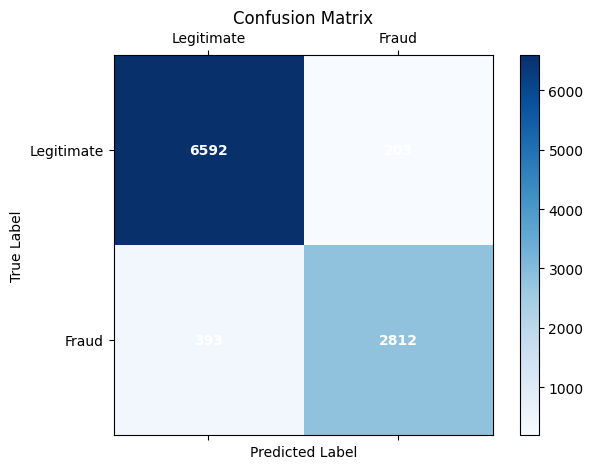

In [33]:
cmap = plt.get_cmap('Blues')

cm = confusion_matrix(all_labels, all_preds)

fig, ax = plt.subplots()
im = ax.matshow(cm, cmap=cmap)

class_labels = ['Legitimate', 'Fraud']
ax.set_xticks(np.arange(cm.shape[1]))
ax.set_yticks(np.arange(cm.shape[0]))

ax.set_xticklabels(class_labels)
ax.set_yticklabels(class_labels)



for i in range(cm.shape[0]):
    for j in range(cm.shape[1]):
        ax.text(j, i, str(cm[i, j]),
                va='center', ha='center',
                color='white', fontsize=10, fontweight='bold')

plt.xlabel('Predicted Label')
plt.ylabel('True Label')
plt.title('Confusion Matrix')
plt.colorbar(im)
plt.tight_layout()
plt.show()

--- Confusion Matrix Cell Colors (Grayscale) ---
Mapping: Low Value -> White, High Value -> Black
--------------------------------------------------
Cell (0, 0):
  Value: 6592
  Normalized Value (0-1): 1.0000
  Grayscale Color (RGB): (0.03, 0.19, 0.42)
  Grayscale Color (Hex): #08306b
--------------------
Cell (0, 1):
  Value: 203
  Normalized Value (0-1): 0.0000
  Grayscale Color (RGB): (0.97, 0.98, 1.00)
  Grayscale Color (Hex): #f7fbff
--------------------
Cell (1, 0):
  Value: 393
  Normalized Value (0-1): 0.0297
  Grayscale Color (RGB): (0.95, 0.97, 0.99)
  Grayscale Color (Hex): #f2f7fd
--------------------
Cell (1, 1):
  Value: 2812
  Normalized Value (0-1): 0.4084
  Grayscale Color (RGB): (0.57, 0.76, 0.87)
  Grayscale Color (Hex): #91c3de
--------------------

--- Summary of Expected Grayscale Appearance ---
Top-Left (3712): Light-to-Medium Gray (closer to the min value)
Top-Right (64): Very Light Gray / Close to White (very low value)
Bottom-Left (16): White / Extremely Light

C:\Users\dudec\AppData\Local\Temp\ipykernel_33432\2807856119.py:2: MatplotlibDeprecationWarning: The get_cmap function was deprecated in Matplotlib 3.7 and will be removed in 3.11. Use ``matplotlib.colormaps[name]`` or ``matplotlib.colormaps.get_cmap()`` or ``pyplot.get_cmap()`` instead.
  cmap = mpl_cm.get_cmap('Blues')


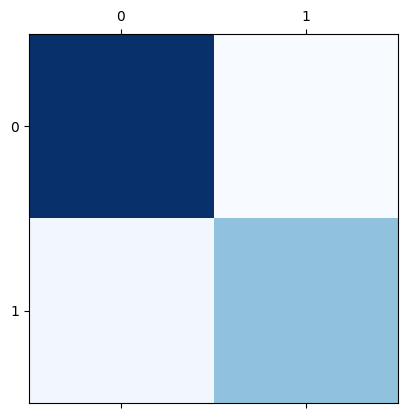

In [34]:
#For values without plot
cmap = mpl_cm.get_cmap('Blues')
cm = confusion_matrix(all_labels, all_preds)
fig, ax = plt.subplots()
im = ax.matshow(cm, cmap= cmap)

norm = matplotlib.colors.Normalize(vmin=cm.min(), vmax=cm.max())

print("--- Confusion Matrix Cell Colors (Grayscale) ---")
print("Mapping: Low Value -> White, High Value -> Black")
print("-" * 50)

for i in range(cm.shape[0]):
    for j in range(cm.shape[1]):
        cell_value = cm[i, j]

        normalized_value = norm(cell_value)

        rgba_color = cmap(normalized_value)

        hex_color = matplotlib.colors.to_hex(rgba_color)

        print(f"Cell ({i}, {j}):")
        print(f"  Value: {cell_value}")
        print(f"  Normalized Value (0-1): {normalized_value:.4f}")
        print(f"  Grayscale Color (RGB): ({rgba_color[0]:.2f}, {rgba_color[1]:.2f}, {rgba_color[2]:.2f})")
        print(f"  Grayscale Color (Hex): {hex_color}")
        print("-" * 20)

print("\n--- Summary of Expected Grayscale Appearance ---")
print("Top-Left (3712): Light-to-Medium Gray (closer to the min value)")
print("Top-Right (64): Very Light Gray / Close to White (very low value)")
print("Bottom-Left (16): White / Extremely Light Gray (the lowest value)")
print("Bottom-Right (33144): Black / Very Dark Gray (the highest value)")
print("-" * 50)

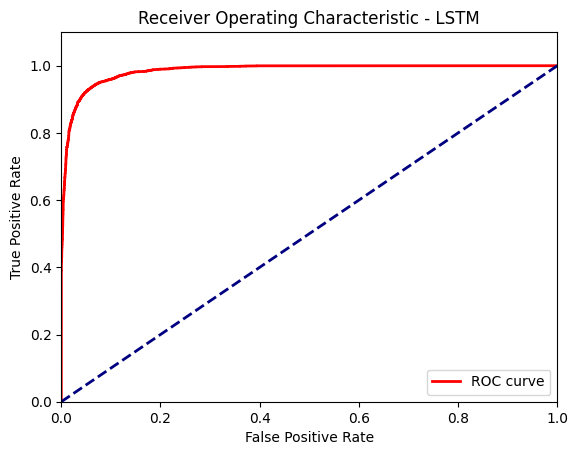

In [36]:
fpr, tpr, thresholds = roc_curve(all_labels, all_probs[:, 1])  # Prob for class 1
roc_auc = auc(fpr, tpr)

plt.figure()
plt.plot(fpr, tpr, color="red", lw=2, label=f"ROC curve")
plt.plot([0, 1], [0, 1], color="navy", lw=2, linestyle="--")
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.1])
plt.xlabel("False Positive Rate")
plt.ylabel("True Positive Rate")
plt.title("Receiver Operating Characteristic - LSTM")
plt.legend(loc="lower right")
plt.show()

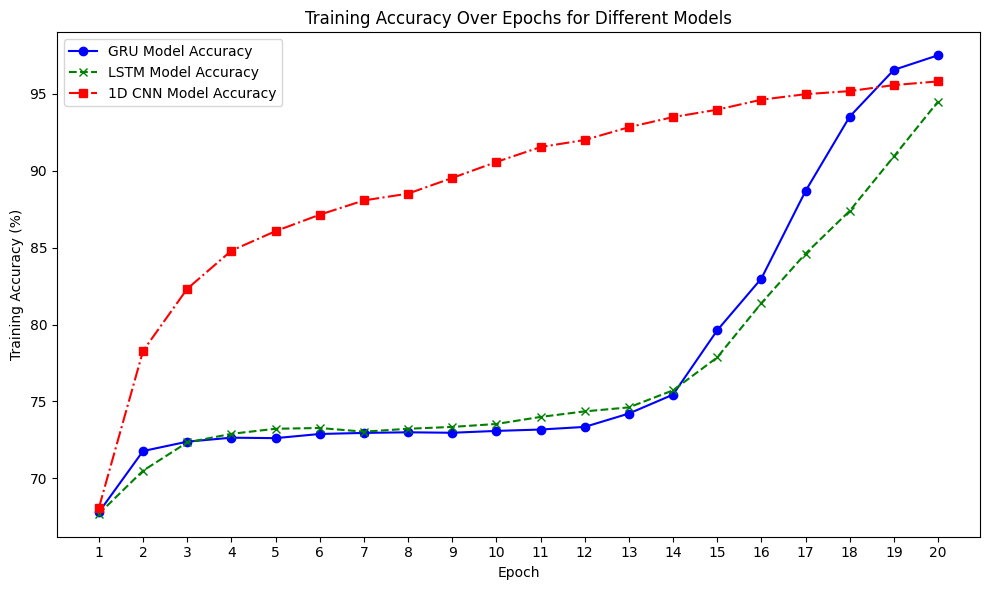

In [32]:
num_epochs = len(taccuracy_gru)
epochs = range(1, num_epochs + 1)

plt.figure(figsize=(10, 6))
plt.plot(epochs, taccuracy_gru, label='GRU Model Accuracy', marker='o', linestyle='-', color='blue')
plt.plot(epochs, taccuracy_lstm, label='LSTM Model Accuracy', marker='x', linestyle='--', color='green')
plt.plot(epochs, taccuracy_1dcnn, label='1D CNN Model Accuracy', marker='s', linestyle='-.', color='red')

plt.title('Training Accuracy Over Epochs for Different Models')
plt.xlabel('Epoch')
plt.ylabel('Training Accuracy (%)')
plt.legend()
# plt.grid(True)
plt.xticks(epochs)
plt.tight_layout()
plt.show()

In [33]:
model_dir = 'models'
os.makedirs(model_dir, exist_ok=True)
model_path = os.path.join(model_dir, 'synfraud_model.pth')


torch.save(model.state_dict(), model_path)
print(f"\nModel saved to {model_path}")


Model saved to models\synfraud_model.pth
